# Get a LSST Simulated Cadence for Single Field
___


___

In [1]:
"""

"""
%matplotlib inline
# %matplotlib notebook

from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import os
import sys
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

import pyCoCo as pccsims
import pycoco as pcc

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [2]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
opsimdbpath = os.environ.get('OPSIMDBPATH')
print(opsimdbpath)
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db


Check that the db looks as we expect

In [3]:
opsimdf.head()

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,1,1016,54,316,1.676483,-1.082473,y,2922,59580.033829,0,...,0.0,105.610378,0.920473,0.0,0.0,1.620307,0.000000,21.021236,1.643930,-1.108924
1,2,1016,54,372,1.694120,-1.033972,y,2961,59580.034275,0,...,0.0,105.167017,0.920473,0.0,0.0,0.049266,4.574944,21.026646,1.664257,-1.060423
2,3,1016,54,441,1.708513,-0.985271,y,2999,59580.034722,0,...,0.0,104.849578,0.920473,0.0,0.0,0.049298,4.595615,21.030520,1.680878,-1.011722
3,4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,...,0.0,104.669398,0.920473,0.0,0.0,0.049266,4.605366,21.032718,1.694604,-0.962927
4,5,1016,54,587,1.730248,-0.887672,y,3077,59580.035616,0,...,0.0,104.627207,0.920473,0.0,0.0,0.049177,4.604023,21.033233,1.706054,-0.914123


Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [4]:
working_df = opsimdf

In [5]:
working_df = utils.find_MW_extinction(working_df)

allfields_df = utils.get_field_corners(
    pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec', 'EBV_MW']])

## Choosing Position and Identifying Fields
___

Choose a fieldID to to give us a position.

### Deep Drilling Fields:
___

* minion2016: 1427,744,2412,290,2786
* astro_lsst_01_1068: 1427,744,2412,290,2786
* Fake_Rolling: 290,2786

In [6]:
chosen_fieldID = 2786

field_df = allfields_df.loc[allfields_df['fieldID'] == chosen_fieldID]

In [7]:
field_df = utils.field_df_to_pos_df(field_df)
field_df.head()

,fieldID,fieldRA,fieldDec,EBV_MW,RA_upper,RA_lower,Dec_upper,Dec_lower,theta,phi
1741,2786,2.624318,0.049506,0.017592,2.654861,2.593775,0.018963,0.080049,-0.517275,0.049506


## Extinction

Get the Milky Way extinction along the line of site towards the SNe. The working_df contains the EBV_MW at the field centre.

In [8]:
extinction = field_df["EBV_MW"].values[0]
print(extinction)

0.0175924399816


## Simulating
------
inputs:

* **`snname`**
* **`redshift`**
* **`absmag offset`**
* **`EBV MW`**
* **`EBV Host`**
* **`Rv`**
* **`MJD at Peak`**

* **`MJD to simulate`**
* **`filters to simulate`**
----

#### Epochs and filters

* pull MJD and filters from df where fieldID matches 

In [9]:
mjd_to_sim = working_df["expMJD"][working_df["fieldID"].isin(field_df["fieldID"].values)].values
limiting_mags = working_df["fiveSigmaDepth"][working_df["fieldID"].isin(field_df["fieldID"].values)].values

filters_to_sim = working_df["filter"][working_df["fieldID"].isin(field_df["fieldID"].values)].values
filters_to_sim = np.array([utils.b('LSST_'+x) for x in filters_to_sim])

In [10]:
filter_path =  pcc._default_filter_dir_path
coco_root_path = pcc._default_coco_dir_path 

coco = pccsims.pyCoCo(utils.b(filter_path), utils.b(coco_root_path))

In [11]:
snname = "SN2007uy"

sn = pcc.SNClass(snname)

In [71]:
z_obs = sn.info["z_obs"]

host_EBV = 0.0

extinction = 0.0
MW_EBV = extinction

print(extinction)

# mjdmax = 60307.314753999999
mjdmax = 59580 + 1.* 365. ## DDF 2786
# mjdmax = 59580 + 1.5* 365. ## WFD 550
# mjdmax = 59580 + 1.3* 365. ## WFD 2297

# field_df = pd.DataFrame({"fieldID" : [2786]})

0.0


In [72]:
verbose = False
if verbose:
    print(mjdmax)
    print(mjd_to_sim)
    print(filters_to_sim)

In [73]:
flux, flux_err = coco.simulate(utils.b(snname), 
                    z_obs, 0.0, MW_EBV, host_EBV, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

In [74]:
flux, flux_err

(array([  0.00000000e+000,   3.84354947e-049,   3.84390511e-049, ...,
          8.12187368e-148,   8.12153206e-148,   8.12119045e-148]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))

In [75]:
print(np.nanmax(flux))
print(mjdmax)

1.45472782597e-15
59945.0


We can now look at the specphot directly

In [76]:
phase, sp_flux = coco.spec_photometry(b"SN2007uy", z = z_obs, flt = b"LSST_r")


(0, 1.5274642172659726e-15)

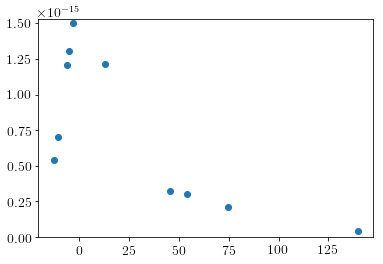

In [77]:
plt.scatter(phase, sp_flux)
plt.ylim(0, np.nanmax(flux)*1.05)

In [78]:
# reload(pcc.classes)

In [79]:
flux_limit = 1e-20

p = pcc.PhotometryClass()
phot_table = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)
phot_table = phot_table[np.where(phot_table["flux"] > flux_limit)]
p.load_table(phot_table)

/Users/berto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


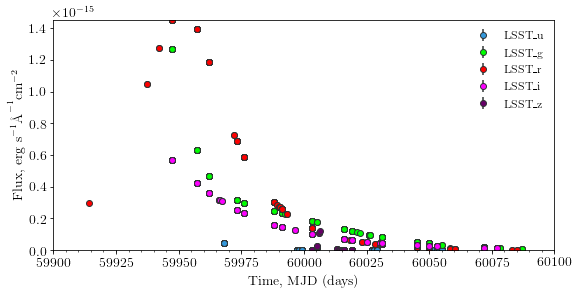

In [80]:
# p.plot(["LSST_r"], xlim = [59995, 60100])
p.plot(xlim = [59900, 60100])
# p.plot(["LSST_r", "LSST_g"], xlim = [59900, 60100])

## With Extinction - Priors need to respond?

In [11]:
snname = "SN2007uy"

sn = pcc.SNClass(snname)

In [61]:
z_obs = sn.info["z_obs"]

host_EBV = 0.0

MW_EBV = extinction
print(extinction)
# MW_EBV = 0.0

# mjdmax = 60307.314753999999
mjdmax = 59580 + 1.* 365. ## DDF 2786
# mjdmax = 59580 + 1.5* 365. ## WFD 550
# mjdmax = 59580 + 1.3* 365. ## WFD 2297

# field_df = pd.DataFrame({"fieldID" : [2786]})

0.0175924399816


In [62]:
verbose = False
if verbose:
    print(mjdmax)
    print(mjd_to_sim)
    print(filters_to_sim)

In [63]:
flux, flux_err = coco.simulate(utils.b(snname), 
                    z_obs, 0.0, MW_EBV, host_EBV, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

In [64]:
flux, flux_err

(array([  2.74085951e-91,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))

In [65]:
print(np.nanmax(flux))
print(mjdmax)

2.95898895502e-15
59945.0


We can now look at the specphot directly

In [66]:
phase, sp_flux = coco.spec_photometry(b"SN2007uy", z = z_obs, flt = b"LSST_r")


(0, 3.1069384027681743e-15)

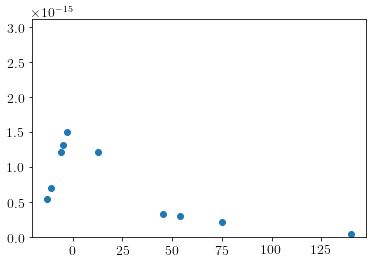

In [67]:
plt.scatter(phase, sp_flux)
plt.ylim(0, np.nanmax(flux)*1.05)

In [68]:
# reload(pcc.classes)

In [69]:
flux_limit = 1e-20

p = pcc.PhotometryClass()
phot_table = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)
phot_table = phot_table[np.where(phot_table["flux"] > flux_limit)]
p.load_table(phot_table)

/Users/berto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


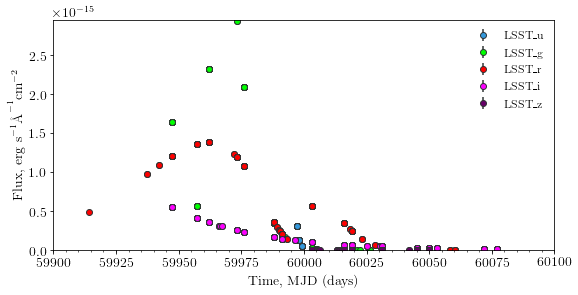

In [70]:
# p.plot(["LSST_r"], xlim = [59995, 60100])
p.plot(xlim = [59900, 60100])
# p.plot(["LSST_r", "LSST_g"], xlim = [59900, 60100])